# Code for CNN tests

In [1]:
# run this before restarting
del train_dataset, valid_dataset, dataloaders_train, dataloaders_valid, dataiter

NameError: name 'train_dataset' is not defined

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, '../')
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from torch import nn, optim
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, median_absolute_error
from mlflood.dataset import load_dataset, load_test_dataset, dataloader_tr_val, dataloader_test
from mlflood.dataset_visualization import visualize_batch, visualize_sample
from mlflood.models.CNN_base import CNN_base
from mlflood.models.unet import UNet
from mlflood.models.Baseline import Baseline
from mlflood.loss import l1_loss_weight, l2_loss, l1_loss, l1_loss_multiple_outs
from torchsummary import summary
import numpy as np
import datetime
import time
import copy
from torch.utils.tensorboard import SummaryWriter
from mlflood.evaluation import predict_batch, predict_event, mae_event, predict_dataset, predict_next_ts
from mlflood.evaluation import plot_metric_event, multiboxplot, plot_answer_sample, boxplot_metric, plot_pie, plot_wd_evol
from mlflood.evaluation import numpy2movie 
from mlflood.training import training_loop

In [4]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

In [5]:
catchment_num = "709_new"
border_size = 0
timestep = 1
lead_time = 6
accumulate_rain = False
add_dry_timesteps = 0
model_name = "unet"
use_diff_dem = False
use_topo_index = True
ts_out  = 1
convlstm = None

# parameter for the catchment
catchment_kwargs = {}
catchment_kwargs["tau"] = 0.5
catchment_kwargs["timestep"]=timestep      # for timestep >1 use CNN rolling or Unet
catchment_kwargs["lead_time"]=lead_time
catchment_kwargs["accumulate_rain"] = accumulate_rain
catchment_kwargs["add_dry_timesteps"] = add_dry_timesteps
catchment_kwargs["sample_type"]="single"
catchment_kwargs["dim_patch"]=256
catchment_kwargs["fix_indexes"]=False
catchment_kwargs["border_size"] = border_size
catchment_kwargs["use_diff_dem"] = use_diff_dem
catchment_kwargs["use_topo_index"] = use_topo_index
catchment_kwargs["ts_out"] = ts_out 

# optimization paramters
optimization_kwargs = {}
optimization_kwargs["batch_size"] = 4
optimization_kwargs["epochs"] = 100
optimization_kwargs["learning_rate"] = 0.0001
optimization_kwargs["weight_d"] = 0.0001 
optimization_kwargs["loss_function"] = l1_loss

#date = datetime.datetime.now().strftime("%Y%m%d")
date = "20220803"
# experiment_name = f"{date}-{catchment_num}-{model_name}-{border_size}-{timestep}-{normalize_output}-{ts_out}"

# changed the naming convention on May 11
experiment_name = f"{date}-{catchment_num}-{model_name}-{lead_time}-{accumulate_rain}-{use_diff_dem}-{use_topo_index}"

In [6]:
path_loc = '/scratch/tdonauer/tabea_mt/experiments/20220803-exp_lead6-709_new/20220803-709_new-unet-6-False-False-True'

In [7]:
train_dataset, valid_dataset = load_dataset(catchment_num=catchment_num, **catchment_kwargs)
dataloaders_train, _ = dataloader_tr_val(train_dataset, valid_dataset, catchment_num = "709", batch_size = 8)
n_input_channels = train_dataset.input_channels

Load file: /scratch/tdonauer/tabea_mt/notebooks/../data/generated_datasets/709_new-train.h5
Load file: /scratch/tdonauer/tabea_mt/notebooks/../data/generated_datasets/709_new-val.h5


In [8]:
# visualize one training batch

dataiter = iter(dataloaders_train)
batch = dataiter.next()
sample = train_dataset[0]
input=batch['x'].shape
print(input)
# pgf settings
import matplotlib



matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    "font.size":16
})


#visualize_batch(batch, use_diff_dem, use_topo_index)
#visualize_sample(sample, use_diff_dem, use_topo_index)
#plt.imshow(train_dataset.waterdepth[1][12, 600:800, 600:800])
#plt.colorbar()
#plt.hist(train_dataset.waterdepth[1][12], bins=100)

torch.Size([8, 9, 256, 256])


##### TI and Elevation

In [35]:
input, target = sample['x'], sample['y']

# define figure size
fig, axs = plt.subplots(ncols=1)#input.shape[0]+1)
plot_width = 12
plot_length = 0.3*plot_width
plt.rcParams['figure.figsize'] = [plot_width, plot_length]


cmaps = ['copper', 'copper', 'viridis', 'RdBu_r', 'RdBu_r']
titles = ['Elevation [-]', 'TI [-]', 'rainfall: t=55', 'water depth: t=55', 'target water depth: t=60']

from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot input
for col in range(8,9):
    img = input[col,:,:]
    ax = axs
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(img, cmap = 'Blues', vmin=0, vmax = 0.08)
    fig.colorbar(im, cax = cax)
    ax.set_title('wd [-]: t = -20min')
   
#plt.suptitle("Patch: " + str(sample['index_s']) + ', Timestep: '+ str(sample['timestep']) + ', Event:' + str(sample['index_e']), fontsize=36, weight='bold')      
#plt.show()
plt.tight_layout()

#fig.savefig("/scratch/tdonauer/tabea_mt/plots/training_data/wd.pdf", bbox_inches = 'tight', dpi=300, pad_inches = 0)
fig.savefig("/scratch/tdonauer/tabea_mt/plots/training_data/wd-20.jpg",bbox_inches = 'tight', dpi=3000, pad_inches = 0)

In [62]:
plt.close('all')

# define figure size
fig, axs = plt.subplots(ncols=6, figsize=(24,4))
plt.rcParams.update({'font.size': 20})

cmaps = ['copper', 'copper', 'viridis', 'RdBu_r', 'RdBu_r']
titles = ['rain [-]: t = 0min', 'rain [-]: t = 5min', 'rain [-]: t = 10min','rain [-]: t = 15min','rain [-]: t = 20min','rain [-]: t = 25min','rain [-]: t = 55']
#'water depth: t=55', 'target water depth: t=60']

from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot input
for col in range(6):
    img = input[col+2,:,:]
    ax = axs[col]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(img, cmap = 'viridis_r', vmin=0, vmax=0.25)#cmaps[col])
    fig.colorbar(im, cax = cax)
    ax.set_title(titles[col])
   
#plt.suptitle("Patch: " + str(sample['index_s']) + ', Timestep: '+ str(sample['timestep']) + ', Event:' + str(sample['index_e']), fontsize=36, weight='bold')      
plt.tight_layout()

#fig.savefig("/scratch/tdonauer/tabea_mt/plots/training_data/rain.pdf", bbox_inches = 'tight', dpi=300, pad_inches = 0)
fig.savefig("/scratch/tdonauer/tabea_mt/plots/training_data/rain.jpg",bbox_inches = 'tight', dpi=1000, pad_inches = 0)

In [33]:
import cv2
mask = train_dataset.dem_mask
plt.imshow(mask)
plt.show()

kernel = np.ones((100, 100), np.uint8)  
import scipy
from scipy import ndimage
mask_eroded=ndimage.binary_erosion(mask, structure=np.ones((3,3)))
dem=train_dataset.dem
dem = torch.masked_select(dem, mask)

NameError: name 'train_dataset' is not defined

In [17]:
if model_name=="cnn":
    model = CNN_base(border_size=border_size, timestep = timestep, n_input_channels=n_input_channels, use_diff_dem=use_diff_dem, use_topo_index=use_topo_index, ts_out = ts_out)
elif model_name == "unet":
    model = UNet(border_size=border_size, timestep = timestep, n_input_channels=n_input_channels, use_diff_dem=use_diff_dem, use_topo_index=use_topo_index)
model = model.to(device)
# summary(model, input_size=(7, 256, 256))

In [15]:
# # -----------
# local_batch = next(iter(dataloaders_train))
# local_x = local_batch['x'].to(device) 
# local_y = local_batch['y'].to(device) 
# local_mask = local_batch['mask'].to(device) 
# predictions = model(local_x, local_mask)
# # -----------

In [ ]:
model, history = training_loop(model, dataloaders_train, dataloaders_valid, optimization_kwargs, device, path_loc)

The number of timesteps for event 5 is 43


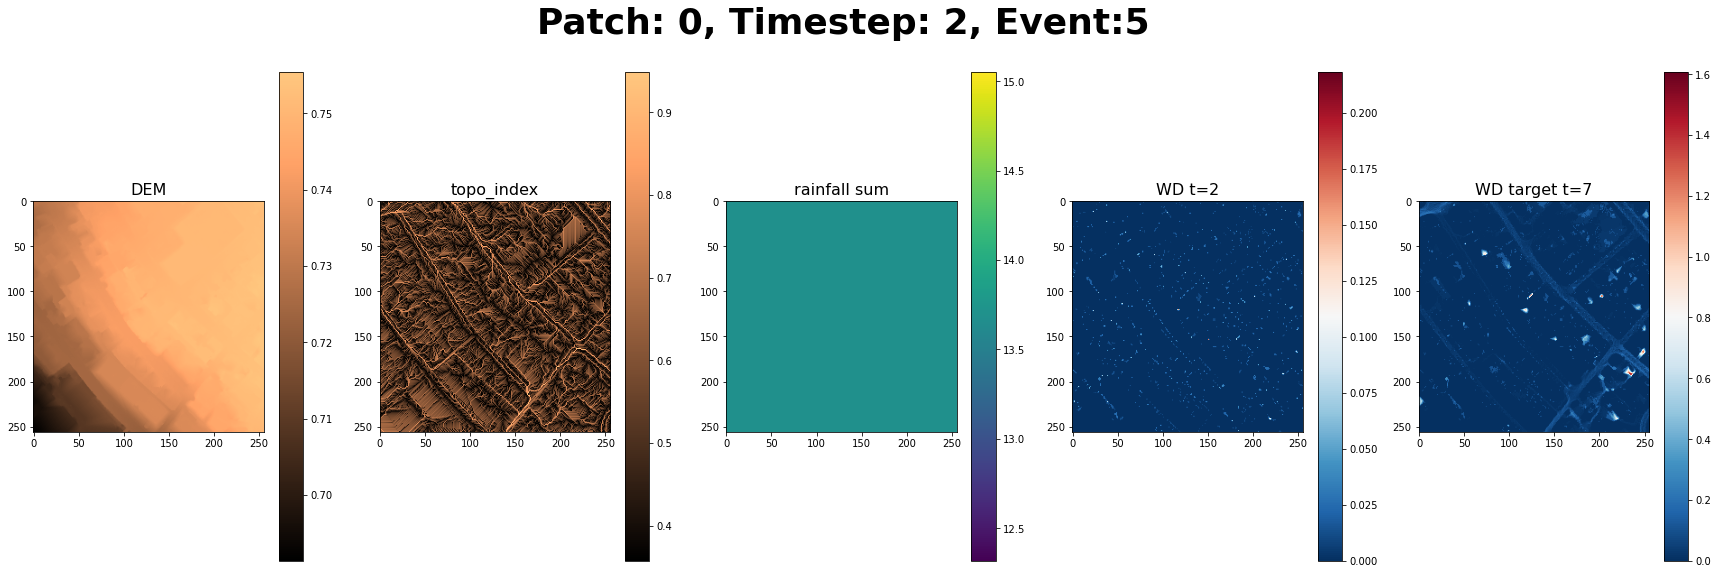

In [11]:
# visualize WD map for specific event, timestep and patch
index_e, index_t = 5, 2
index_patch=23
print("The number of timesteps for event", index_e, "is", train_dataset.T_steps[index_e])

# construct overall index, is there a more elegant way to do it?
idx = np.where((train_dataset.indexes_e==index_e) & (train_dataset.indexes_t==index_t))[0]
if train_dataset.fix_indexes:
    sample=train_dataset[len(train_dataset.inds)*(idx[0])+index_patch]
else:
    sample=train_dataset[idx[0]]

# visualize sample
visualize_sample(sample, use_diff_dem, use_topo_index)

In [17]:
ep = np.arange(1, optimization_kwargs["epochs"]+1)
train_loss = history['train_loss']
val_loss = history['val_loss']
plt.plot(ep, train_loss, label="Training Loss")
plt.plot(ep, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.legend()
plt.rcParams['figure.figsize'] = [8, 8]


# Reconstructions

In [9]:
catchment_kwargs["fix_indexes"] = True
patch_dim = catchment_kwargs["dim_patch"]
border_size = catchment_kwargs["border_size"]

test_dataset = load_test_dataset(catchment_num=catchment_num, **catchment_kwargs)
dataloaders_test = dataloader_test(test_dataset, catchment_num = "709", batch_size = 8)

Load file: /scratch/tdonauer/tabea_mt/notebooks/../data/generated_datasets/709-test.h5


In [ ]:
# Load pretrained model
# date = datetime.datetime.now().strftime("%Y%m%d")
date = "20220530"
experiment_name = f"{date}-{catchment_num}-{model_name}-{lead_time}-{accumulate_rain}-{use_diff_dem}-{use_topo_index}"
path_loc = '/scratch/tdonauer/tabea_mt/data/709_experiments/20220530-exp_unet/' + experiment_name
model_p = path_loc + "/trained_model.pth"
model = torch.load(model_p)  # Load
model.eval()

In [24]:
# predict a specific event
event_num = 1
start_ts = 0
lims = [0.1, 0.2, 0.5, 1]


pred_unet, gt_unet, mask_unet = predict_event(model, test_dataset, event_num, start_ts=start_ts, ar = False, ts_out = ts_out)
boxplot_unet=boxplot_metric(pred_unet, gt_unet, test_dataset.dem_mask, lims, pred_ts = None, metric="mae")
#pred_cnn, gt_cnn, mask_cnn = predict_event(model, test_dataset, event_num, start_ts=start_ts, ar = False, ts_out = ts_out)
#boxplot_cnn=boxplot_metric(pred_cnn, gt_cnn, test_dataset.dem_mask, lims, pred_ts = None, metric="mae")

#pred_ar, gt_ar, mask_ar = predict_event(model, test_dataset, event_num, start_ts=start_ts, ar = True, ts_out = ts_out)
#baseline=Baseline(border_size=border_size, normalize_output=False, use_diff_dem=use_diff_dem, use_topo_index=use_topo_index)
#pred_base, gt_base, mask_base = predict_event(model, test_dataset, event_num, start_ts=start_ts, ar = True, ts_out = ts_out)

100%|██████████| 54/54 [00:42<00:00,  1.26it/s]


Negative waterdept value: -0.015232069417834282


In [ ]:
for i in range(39):
    pred = pred_unet[i,:]
    gt = gt_unet[i,:]

#zoom=pred_unet[5,500:1000,500:1000]
#zoom_gt = gt_unet[5,500:1000,500:1000]
#plt.imshow(zoom-zoom_gt)
#plt.colorbar()

    selection = np.logical_and(gt>1, gt<15)
    print(gt[selection].shape)
    mean=np.mean(np.abs(pred[selection]-gt[selection]))
    print(mean)

    #plt.imshow(test_dataset.waterdepth[event_num][i])
    #plt.imshow(gt)
    #plt.clim(0,0.01)
    #plt.colorbar()
    #plt.show()
#pred pred[selection], gd[selection]))
#boxplot = [np.abs(split[0]-split[1]).flatten() for split in splits]

In [ ]:
# alternative: predict all events and then select the results from one
predictions_all_events = predict_dataset(model, test_dataset, start_ts=None, ar = False)
pred_cnn, gt_cnn, mask_cnn = predictions_all_events[1]

In [27]:
mae_convlstm = np.load("/scratch/tdonauer/tabea_mt/data/709_experiments/20220630-exp_convlstm/20220630-709-convlstm-1-False-False-True/event_1/mae.npy")
len(mae_convlstm)
a = np.empty(4)
a[:] = np.NaN
mae_convlstm = np.concatenate((a, mae_convlstm))
len(mae_convlstm)
boxplot_convlstm = np.load("/scratch/tdonauer/tabea_mt/data/709_experiments/20220630-exp_convlstm/20220630-709-convlstm-1-False-False-True/event_1/mae_boxplot.npy", allow_pickle=True)


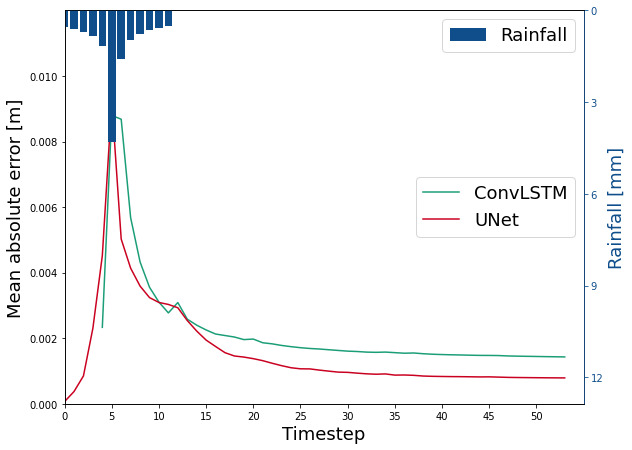

In [28]:
#mae_cnn = mae_event(pred_cnn, gt_cnn, mask_cnn)
mae_unet = mae_event(pred_unet, gt_unet, mask_unet)
#mae_unet = np.concatenate((a, mae_unet))


#mae_base = mae_event(pred_base, gt_base, mask_base)
maes = [mae_convlstm, mae_unet]
labels=['ConvLSTM', 'UNet']
#labels = [model_name]
colors = ['#1B9E77', '#CA0020']

#colors = ['#EF8A62', '#67A9CF', '#1B9E77', '#CA0020', '#998EC3']

plot_metric_event(maes, labels, colors, start_ts=0, save_folder = "/scratch/tdonauer/tabea_mt/plots/", rainfall_series = test_dataset.rainfall_events[event_num], name = 'models', title = None)

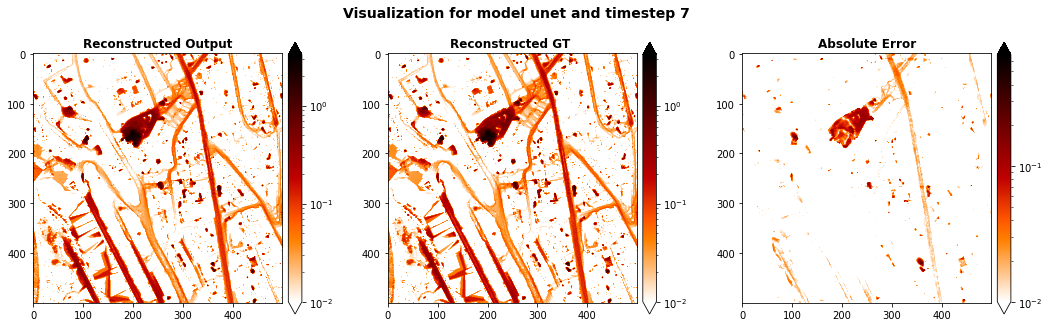

In [17]:
zoom = [500,1000,500,1000]
plot_answer_sample(pred_unet, gt_unet, mask_unet, ts=7, zoom=zoom, show_diff=False, global_scale=False, save_folder = None, model_name = model_name)

In [49]:
# Compute Loss
current_ts = 7
loss_tot = np.abs(pred_unet[current_ts] - gt_unet[current_ts])
loss_mean = np.sum(loss_tot)/torch.sum(test_dataset.dem_mask)

print("Loss for event {} and timestep {} is {:.4f} ".format( event_num, current_ts,loss_mean ))

Loss for event 1 and timestep 7 is 0.0367 


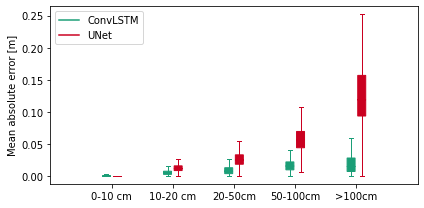

In [18]:
lims = (0.1,0.2, 0.5, 1)
#data_cnn = boxplot_mae(pred_cnn, gt_cnn, mask_cnn, lims=lims, pred_ts = pred_ts)

data = [boxplot_convlstm, boxplot_unet]
ticks = ['0-10 cm', '10-20 cm', '20-50cm', '50-100cm','>100cm']
labels = ['ConvLSTM', 'UNet']
colors = ['#1B9E77', '#CA0020']

#colors = ['#EF8A62', '#67A9CF', '#1B9E77', '#CA0020', '#998EC3']

multiboxplot(data, ticks, labels, colors, save_folder='/scratch/tdonauer/tabea_mt/plots/', name='convlstm_boxplot', title = None)

# Autoregressive

In [15]:
event_num = 2
start_ts = 3

pred_cnn, gt_cnn, mask_cnn = predict_event(model, test_dataset, event_num, start_ts, ar = True, ts_out = ts_out)

100%|██████████| 36/36 [00:17<00:00,  2.06it/s]


In [24]:
zoom = [500,1000,500,1000]
plot_answer_sample(pred_cnn, gt_cnn, mask_cnn, ts=8, zoom=zoom, show_diff=False, global_scale=False, save_folder = None, model_name = 'cnn_ar')

Negative waterdept value: -0.29687070846557617


Text(0.5, 1.0, 'Visualization for model unet ')

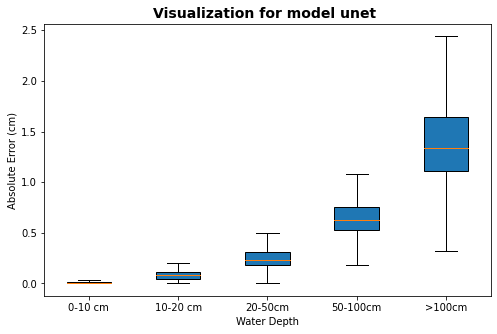

In [23]:
lims = (0.1,0.2, 0.5, 1)
pred_ts = 12
data_cnn = boxplot_mae(pred_cnn, gt_cnn, mask_cnn, lims=lims, pred_ts = pred_ts)

model_name = 'unet'
data = data_cnn
ticks = ['0-10 cm', '10-20 cm', '20-50cm', '50-100cm','>100cm']
labels = ['cnn', 'graph', 'baseline']
colors = ['#EF8A62', '#67A9CF', '#1B9E77', '#CA0020', '#998EC3']

fig, ax = plt.subplots(figsize = [8,5])
ax.set_ylabel('Absolute Error (cm)')
ax.set_xlabel('Water Depth')
flierprops = dict(marker='d', markerfacecolor='black', markersize=4, linestyle='none', markeredgecolor='black')
bp = ax.boxplot(data, showfliers=False, patch_artist=True, flierprops=flierprops)                                #‘Hide Outlier Points’
ax.set_xticklabels(ticks)
plt.title("Visualization for model {} ".format(model_name), fontsize = 14 ,fontweight="bold")

In [18]:
mae_cnn = mae_event(pred_cnn, gt_cnn, mask_cnn )
maes = [mae_cnn]
print(mae_cnn)
labels = ['cnn']   
#plot_maes(maes, labels, start_ts=3, save_folder = None, name = '1_ts_ahead', title = "MAE for AR mode")

[0.00822869 0.02026015 0.02481373 0.03096666 0.0355139  0.03834329
 0.04031837 0.04181449 0.04309455 0.04314132 0.04299528 0.04271058
 0.04233672 0.04192494 0.0414801  0.04099589 0.0404565  0.03988509
 0.03931826 0.03876754 0.03824466 0.03775666 0.03730679 0.03689473
 0.03651794 0.03617686 0.03586618 0.03558465 0.03533277 0.03510639
 0.03490064 0.03470736 0.03452994 0.03436628 0.03421422 0.03407407]


## Animations

In [ ]:
animation = numpy2movie(pred_cnn, gt_cnn)
animation.ipython_display(fps=10, loop=True, autoplay=True)